# Diabetic Retinopathy Classification with Deep Learning

## Introduction

**Problem Statement:** Diabetic retinopathy is a diabetes-related eye disease that affects the blood vessels in the retina. It is a leading cause of blindness in diabetic individuals. Early detection and timely intervention are crucial in preventing vision loss. Deep learning models have shown promise in automating the classification of diabetic retinopathy into different severity categories from retinal images.

In this project, I aim to develop a deep learning model for the automated classification of diabetic retinopathy into five categories.

## Dataset

**Dataset Source:** Kaggle

**Dataset Description:** I will be using a Kaggle dataset of retinal images containing cases from all five diabetic retinopathy categories. The dataset is labeled with information about the severity of diabetic retinopathy. It is essential to have a reliable and well-annotated dataset for training and evaluating my model.

## Environment

**Notebook Environment:** Kaggle Jupyter Notebook

**Accelerated Computing:** I will utilize a TPU (Tensor Processing Unit) VM with specifications for efficient deep learning computations, specifically the TPU VM v3.8.

## Model Architecture

**Convolutional Neural Networks (CNNs):** My model will be based on CNNs, which are highly effective for image classification tasks. I will experiment with different architectures and hyperparameters to achieve the best possible performance in classifying diabetic retinopathy.

## Evaluation

**Performance Metrics:** I will evaluate the model's performance using standard evaluation metrics such as accuracy, precision, recall, F1-score, and confusion matrices for each severity category.

**Clinical Interpretation:** Additionally, I will consider clinical validation and interpretation of the results to assess the model's practical utility in assisting healthcare professionals.

## Code Overview

The code below implements the diabetic retinopathy classification model using TensorFlow and Keras. I will preprocess the dataset, build the model, train it, and evaluate its performance across all five severity categories.

Let's get started!


# Connecting and Instantiating TPU

The following code cell establishes the connection to a TPU (Tensor Processing Unit) and instantiates it for use in training the deep learning model. TPUs are specialized hardware accelerators that can significantly speed up the training process for deep neural networks.


In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

TensorFlow version: 2.12.0
Number of accelerators:  1


# Data Preprocessing: Image Resizing

In preparation for training our diabetic retinopathy detection model, we perform data preprocessing by resizing the images.

- **Image Directory:** We start with the Kaggle Diabetic Retinopathy Dataset stored in '/kaggle/input/aptos2019-blindness-detection/train_images'.

- **Target Size:** All images are resized to a common target size of (331, 331) pixels, which is suitable for our model.

- **Resized Image Storage:** Resized images are saved in the 'resized_images_final' directory.

- **Resizing Method:** We use the LANCZOS filter for high-quality image resizing.

- **Supportive Preprocessing:** This image resizing step is part of the overall preprocessing pipeline to prepare the data for our diabetic retinopathy detection model.

This ensures that all images are standardized in size before feeding them into the model for training.


In [2]:
from PIL import Image, ImageOps
import os
import shutil

# Define the image directory
image_dir = '/kaggle/input/aptos2019-blindness-detection/train_images'

# Define the target size for resizing
target_size = (331, 331)

# Create a directory to store resized images (if it doesn't exist)
resized_dir = 'resized_images_final'

if(shutil.os.path.exists(resized_dir)):
    shutil.rmtree(resized_dir)
    print(f"Directory '{resized_dir}' has been deleted.")


os.makedirs(resized_dir, exist_ok=True)

# Get a list of image filenames in the directory
image_filenames = os.listdir(image_dir)

# Loop through each image and resize it
for image_filename in image_filenames:
    # Open the image
    image_path = os.path.join(image_dir, image_filename)
    image = Image.open(image_path)
    
    # Resize the image to the target size with LANCZOS filter
    resized_image = ImageOps.fit(image, target_size, Image.LANCZOS)
    
    # Save the resized image to the resized directory
    resized_image.save(os.path.join(resized_dir, image_filename))
    
print(f"Resized {len(image_filenames)} images to {target_size}.")


Resized 3662 images to (331, 331).


# Data Preprocessing: TFRecord Creation

To efficiently handle and load the dataset during training, we convert the resized images into the TFRecord format. This format is optimized for working with large datasets and can significantly accelerate data loading.

- **Image Directory:** We start with the resized images stored in the 'resized_images_final/' directory.

- **Output Directory:** Split TFRecord files are generated and stored in '/kaggle/working/split_tfrecords/'.

- **Number of Split Files:** We create 18 split TFRecord files for effective data management.

- **CSV File for Labels:** Image labels are obtained from the 'train.csv' file, which contains information about each image, including its diagnosis label.

- **Mapping Labels:** We create a dictionary to map image filenames to their corresponding diagnosis labels.

- **TFRecord Encoding:** Images and labels are encoded into TFRecord examples. Images are serialized as bytes, and labels as integers.

- **Splitting Records:** Images and labels are split into multiple TFRecord files to facilitate parallel processing during training.

This TFRecord creation process enhances data efficiency and is an essential step in our diabetic retinopathy detection project.


In [3]:
import tensorflow as tf
import os
import pandas as pd

# Define the directory where your images are stored
image_dir = 'resized_images_final/'

# Define the input TFRecord file
# input_tfrecord = '/kaggle/input/aptos2019-blindness-detection/datasetFinal.tfrecord'

# Define the output directory for split TFRecord files
output_dir = '/kaggle/working/split_tfrecords/'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define the number of split TFRecord files you want to create
num_split_files = 18

# Read the CSV file to get image labels
csv_file = '/kaggle/input/aptos2019-blindness-detection/train.csv'
df = pd.read_csv(csv_file)
print(df.head)
# Create a dictionary to map image filenames to labels
label_dict = dict(zip(df['id_code'], df['diagnosis']))

# Function to encode image and label into a TFRecord example
def create_tfrecord_example(image_path, label):
    with tf.io.gfile.GFile(image_path, 'rb') as f:
        image = f.read()

    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
    }

    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example

# Create a TFRecord writer for each split
for i in range(num_split_files):
    # Create a TFRecord writer for the split
    split_filename = os.path.join(output_dir, f'split_{i}.tfrecord')
    with tf.io.TFRecordWriter(split_filename) as writer:
        # Calculate the range of records to write to this split
        start = i * (len(df) // num_split_files)
        end = (i + 1) * (len(df) // num_split_files)

        for index in range(start, end):
            image_id = df['id_code'][index]
            label = df['diagnosis'][index]
            image_path = os.path.join(image_dir, f"{image_id}.png")
            tf_example = create_tfrecord_example(image_path, label)
            writer.write(tf_example.SerializeToString())


<bound method NDFrame.head of            id_code  diagnosis
0     000c1434d8d7          2
1     001639a390f0          4
2     0024cdab0c1e          1
3     002c21358ce6          0
4     005b95c28852          0
...            ...        ...
3657  ffa47f6a7bf4          2
3658  ffc04fed30e6          0
3659  ffcf7b45f213          2
3660  ffd97f8cd5aa          0
3661  ffec9a18a3ce          2

[3662 rows x 2 columns]>


# Data Preprocessing: TFRecord Data Loading and Preprocessing

We proceed with loading and preprocessing the dataset stored in TFRecord format for efficient training. This step ensures that our diabetic retinopathy detection model is trained on well-preprocessed data.

- **TFRecord Directory:** We start with TFRecord files stored in the 'split_tfrecords/' directory.

- **Image Size and Parameters:** Images are loaded and preprocessed with specified parameters:
    - **Image Size:** Images are resized to [331, 331] pixels for consistency.
    - **Number of Classes:** Our model is designed to classify into 5 classes.
    - **Batch Size:** We use a batch size of 16 (scaled by the number of TPU replicas) for training.
    
- **Validation Split:** A portion of the dataset (20%) is set aside for validation.

- **TFRecord Parsing:** Images and labels are parsed from TFRecord examples using TensorFlow operations.

- **Image Preprocessing:** Images undergo preprocessing to enhance features, including:
    - Conversion to grayscale.
    - Histogram equalization.
    - Normalization to [0, 1].

- **Data Augmentation:** Data augmentation is applied to training data, including random flip and saturation adjustment.

- **Dataset Loading:** Training and validation datasets are created by loading and preprocessing TFRecord data.

This comprehensive preprocessing pipeline prepares our data for training and validation, ensuring that it is well-suited for the diabetic retinopathy detection task.


In [4]:
import tensorflow as tf
import os
import shutil
# import tensorflow.experimental.numpy as tnp  # Import TensorFlow's NumPy API
import cv2
import numpy as np

AUTO = tf.data.experimental.AUTOTUNE

# Define the image size
IMAGE_SIZE = [331, 331]

# Define other parameters
num_classes = 5
batch_size = 16 * strategy.num_replicas_in_sync

# Define the directory path for TFRecord files
tfrecords_dir = 'split_tfrecords/'


# Set the validation split ratio
validation_split = 0.20

# Get the list of TFRecord filenames
filenames = tf.io.gfile.glob(os.path.join(tfrecords_dir, 'split_*.tfrecord'))

# Calculate the split point
split = len(filenames) - int(len(filenames) * validation_split)

# Split filenames into training and validation
train_filenames = filenames[:split]
validation_filenames = filenames[split:]

# Updated TFRecord feature description
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}


def parse_tfrecord(example):
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_png(example['image'], channels=3)
    
    # Convert the image array to 8-bit unsigned integer data type
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # Set the static shape of the image tensor
#     image.set_shape([None, None, 3])  # Assuming 3 channels for RGB images
    
    # Apply image enhancement preprocessing using OpenCV
    def preprocess_image(image):
        img_array = image.numpy()
        img_array_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        img_array_eq = cv2.equalizeHist(img_array_gray)  # Apply histogram equalization
        img_array_eq_rgb = cv2.cvtColor(img_array_eq, cv2.COLOR_GRAY2RGB)  # Convert back to RGB
        # Ensure pixel values are within the expected range (0-255)
        img_array_eq_rgb = np.clip(img_array_eq_rgb, 0, 255)
        # Normalize the image to the range [0, 1] and convert to TensorFlow tensor
        normalized = tf.convert_to_tensor(img_array_eq_rgb / 255.0, dtype=tf.float32)
        return normalized

    image = tf.py_function(preprocess_image, [image], tf.float32)
    
    # Convert to float32 and normalize to [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Set the static shape of the image tensor
    image.set_shape([None, None, 3])  # Assuming 3 channels for RGB images
    
    # Resize the image to the defined size
    image = tf.image.resize(image, IMAGE_SIZE)
    
    label = example['label']
    
    # Convert label to one-hot encoded format
    one_hot_label = tf.one_hot(label, num_classes)
    
    return image, one_hot_label


def load_dataset(filenames):
    records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    return records.map(parse_tfrecord, num_parallel_calls=AUTO)

def data_augment(image, label):
    modified = tf.image.random_flip_left_right(image)
    modified = tf.image.random_saturation(modified, 0, 2)
    return modified, label

def get_training_dataset():
    dataset = load_dataset(train_filenames)
    augmented = dataset.map(data_augment, num_parallel_calls=AUTO)
    return augmented.repeat().shuffle(2048).batch(batch_size).prefetch(AUTO)

def get_validation_dataset():
    return load_dataset(validation_filenames).batch(batch_size).prefetch(AUTO)

# Create training and validation datasets
training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

# Print dataset information
print(training_dataset)
print(validation_dataset)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 331, 331, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 331, 331, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


# Sample Image Visualization

To better understand the data and model performance, we visualize a sample of images from the dataset along with their corresponding labels. This visualization provides insights into the quality and diversity of the dataset.

- **Image Display:** We display a set of nine images in a 3x3 grid, highlighting their characteristics.

- **Labels:** The labels corresponding to each image are displayed as titles below the images. These labels are categorized into five classes:
    - 0: 'No DR'
    - 1: 'Mild'
    - 2: 'Moderate'
    - 3: 'Severe'
    - 4: 'Proliferative DR'

- **Label Mapping:** We map numeric label values to their respective class names using a predefined dictionary.

- **Visualization Function:** We define functions (`display_one_flower` and `display_nine_flowers`) to streamline the image display process.

- **Iterator:** Images are extracted from the training dataset and displayed using the defined functions.

- **Note:** You can re-run this cell to visualize a new batch of images with their labels. This enables you to gain a better understanding of the dataset's content.

This visualization step aids in assessing the dataset's quality and helps visualize how the model performs on different diabetic retinopathy severity levels.


In [5]:

import matplotlib.pyplot as plt

def display_one_image(image, title, subplot, color):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image)
  plt.title(title, fontsize=16, color=color)
  
# If model is provided, use it to generate predictions.
def display_nine_images(images, titles, title_colors=None):
  subplot = 331
  plt.figure(figsize=(13,13))
  for i in range(9):
    color = 'black' if title_colors is None else title_colors[i]
    display_one_image(images[i], titles[i], 331+i, color)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()

training_viz_iterator = get_dataset_iterator(training_dataset, 9)


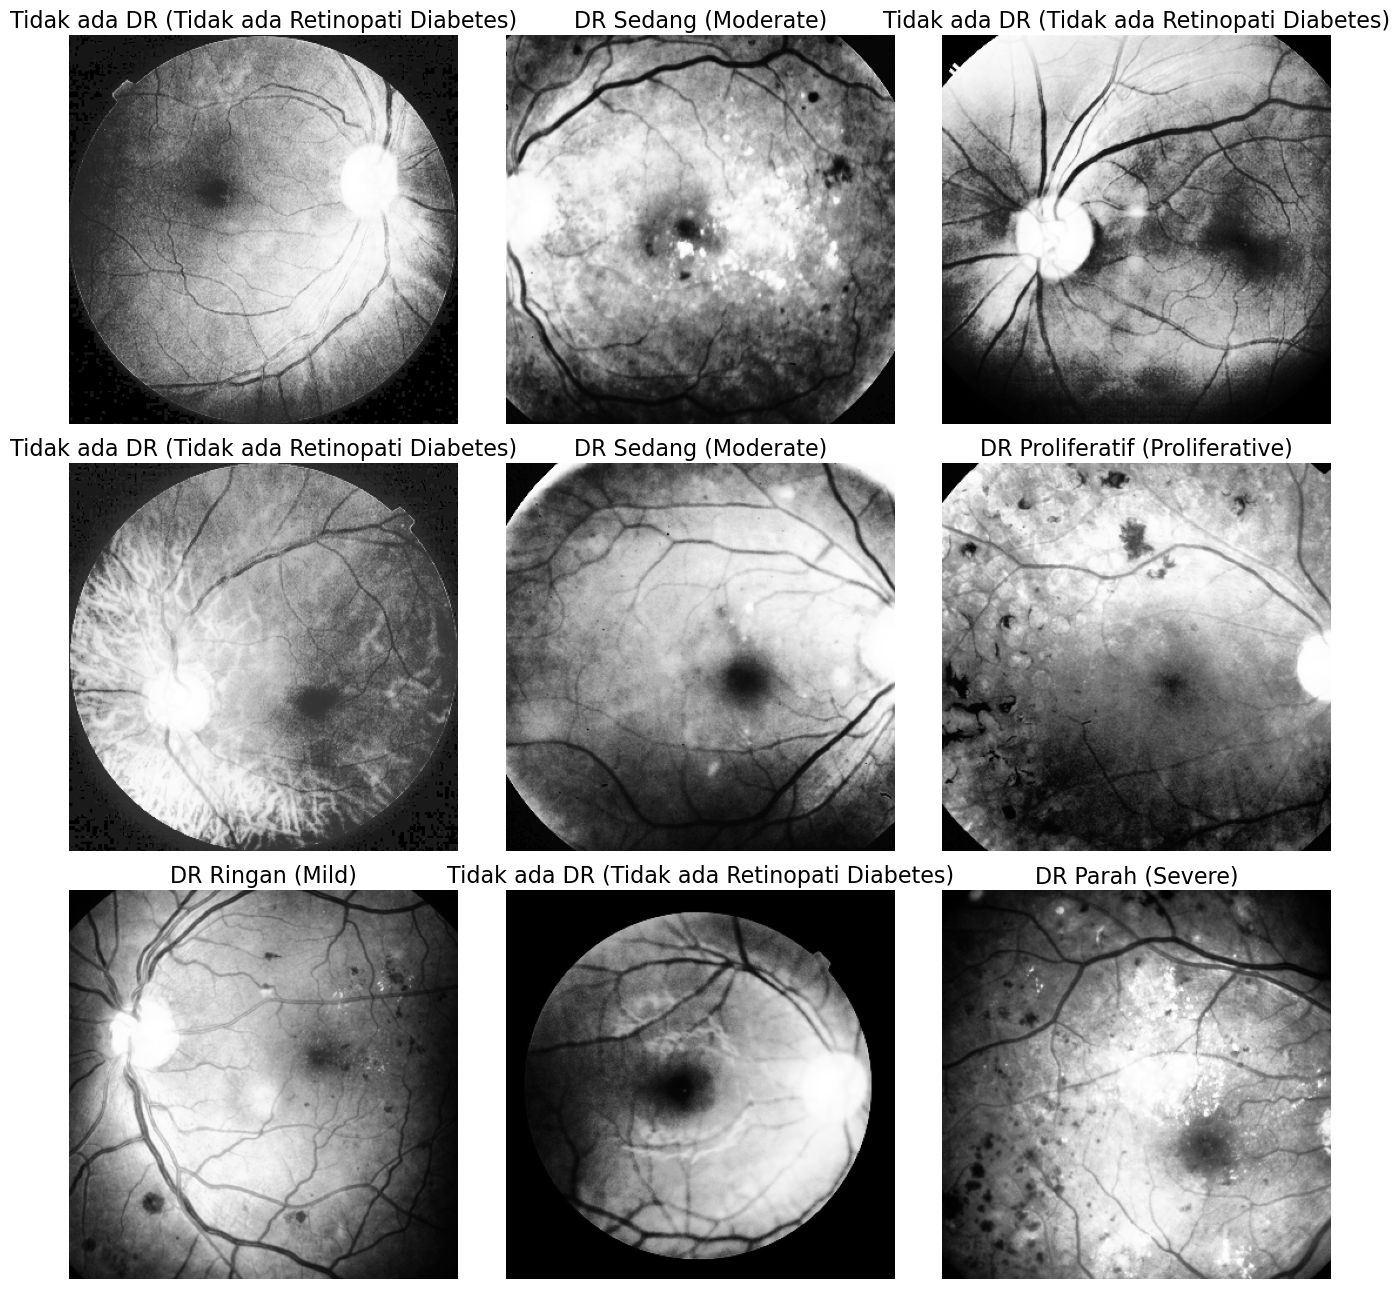

In [6]:

# Define a dictionary to map label numbers to label names
label_names = {
  0: 'Tidak ada DR (Tidak ada Retinopati Diabetes)',
  1: 'DR Ringan (Mild)',
  2: 'DR Sedang (Moderate)',
  3: 'DR Parah (Severe)',
  4: 'DR Proliferatif (Proliferative)'
}
# Re-run this cell to show a new batch of images
images, classes = next(training_viz_iterator)
class_idxs = tf.argmax(classes, axis=-1).numpy() # transform from one-hot array to class number
labels = [label_names[idx] for idx in class_idxs]
display_nine_images(images, labels)


In [7]:
training_viz_iterator = get_dataset_iterator(validation_dataset, 9)

# Class Weights Calculation

Class weights play a crucial role in training a machine learning model, especially when dealing with imbalanced datasets. In this context, we calculate class weights for the training dataset, considering the imbalance in the distribution of diabetic retinopathy severity classes.

- **One-Hot Encoding:** Initially, we extract the one-hot encoded labels for the training dataset. One-hot encoding represents each class with a binary vector, where only one element is "1," corresponding to the class label.

- **Conversion to Normal Labels:** To calculate class weights, we convert these one-hot encoded labels back to the normal label format. The label with the highest value in the one-hot encoding is considered the class label for each instance.

- **Class Weight Computation:** We compute the class weights using the `compute_class_weight` function from the scikit-learn library. These weights are calculated in a way that compensates for class imbalance by assigning higher weights to underrepresented classes and lower weights to overrepresented classes. The parameter `class_weight='balanced'` indicates that we want balanced class weights.

- **Dictionary Format:** Finally, we convert the calculated class weights into a dictionary format expected by TensorFlow. This dictionary maps class indices to their respective class weights. The model can use these weights during training to give more importance to the underrepresented classes.

Class weights are essential for training a model that can effectively handle imbalanced datasets. They help the model focus on learning from the minority classes, which is particularly important for the detection of diabetic retinopathy severity.


In [8]:
# Extract one-hot encoded labels for the training dataset
train_labels_one_hot = []
for record in load_dataset(train_filenames):
    _, one_hot_label = record
    train_labels_one_hot.append(one_hot_label.numpy())

train_labels_one_hot = np.array(train_labels_one_hot)

# Convert one-hot encoded labels back to normal label format
train_labels = np.argmax(train_labels_one_hot, axis=1)

In [9]:
print(train_labels.shape)

(3045,)


In [10]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)

# Convert class_weights to a dictionary format expected by TensorFlow
class_weight_dict = dict(enumerate(class_weights))


In [11]:
print(class_weight_dict)

{0: 0.4057295136575616, 1: 1.9456869009584665, 2: 0.7399756986634265, 3: 3.736196319018405, 4: 2.4857142857142858}


# Model Architecture

The core of our diabetic retinopathy detection solution lies in the architecture of the deep learning model. This section provides an overview of the model structure and hyperparameters used for training.

- **Model Architecture:** We use a Convolutional Neural Network (CNN) as the foundation for our model. The CNN consists of multiple layers that automatically learn hierarchical features from retinal images. The architecture includes convolutional layers for feature extraction, max-pooling layers for down-sampling, and fully connected layers for classification.

- **Convolutional Layers:** The model begins with three convolutional layers, each followed by max-pooling and batch normalization. These layers are responsible for capturing image features at various levels of abstraction.

- **Fully Connected Layers:** After feature extraction, the model includes a stack of fully connected layers. The first fully connected layer has 512 neurons and uses the ReLU activation function. A dropout layer with a rate of 0.4 is applied to mitigate overfitting. The final layer consists of neurons equal to the number of classes (5 in our case) and uses the softmax activation function to output class probabilities.

- **Regularization:** To prevent overfitting, we apply L2 regularization to the convolutional layers. This helps in controlling the complexity of the model.

- **Loss Function:** We use categorical cross-entropy as the loss function, which is suitable for multi-class classification problems like diabetic retinopathy severity detection.

- **Optimizer:** We employ the Adam optimizer for efficient gradient descent during training.

- **Image Preprocessing:** The input images are resized to a common dimension of 331x331 pixels to ensure uniformity.

- **Hyperparameters:** We set the dropout rate to 0.3 and the L2 regularization parameter to 0.0001. These values were chosen through experimentation to balance model complexity and generalization.

This architecture, coupled with appropriate hyperparameters and data augmentation techniques, enables our model to detect diabetic retinopathy severity accurately. The training process leverages these components to learn relevant features from the retinal images and make predictions.


In [12]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2  # Importing l2 regularization
from sklearn.metrics import f1_score
from tensorflow.keras.metrics import Metric

# Create the model
def create_model(input_shape, num_classes, dropout_rate, l2_lambda):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(l2_lambda)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2_lambda)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(l2_lambda)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(l2_lambda)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())


    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use the appropriate loss function for your problem
    metrics=['accuracy']
    )

    return model

# Image dimensions for preprocessing
img_width, img_height = 331, 331

# Define the number of classes
num_classes = 5

# Hyperparameters for regularization and dropout
dropout_rate = 0.4
l2_lambda = 0.0001

# Create the model with TPU strategy
with strategy.scope():
    model = create_model(input_shape=(img_width, img_height, 3), num_classes=num_classes, dropout_rate=dropout_rate, l2_lambda=l2_lambda)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 329, 329, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 164, 164, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 164, 164, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 162, 162, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 81, 81, 128)      0         
 2D)                                                             
                                                        

# Learning Rate Scheduler

To facilitate effective training, we employ a learning rate scheduler. Learning rate scheduling adjusts the learning rate during training to optimize convergence. In our case, we use a custom learning rate scheduler tailored to the specific needs of our diabetic retinopathy detection model.

- **Learning Rate Schedule:** The learning rate starts at 1e-4 and is reduced by 10% after each epoch. This gradual reduction allows the model to initially explore a larger learning rate for faster convergence and then fine-tune with smaller learning rates as it approaches a solution.

- **Number of Epochs:** We schedule this learning rate reduction over a total of 30 epochs. During this period, the learning rate decreases in a controlled manner to enhance the model's ability to converge to an optimal solution.

- **Visualization:** The accompanying plot visualizes the learning rate per epoch. You can observe the gradual decrease in the learning rate as training progresses. This dynamic adjustment is a critical component of the training process and contributes to the model's effectiveness.

The learning rate scheduler helps the model adapt to the training data and find a good balance between rapid convergence and fine-tuning. This dynamic adjustment is especially important when dealing with complex datasets like diabetic retinopathy detection, where finding the right learning rate can significantly impact training results.


Learning rate per epoch:


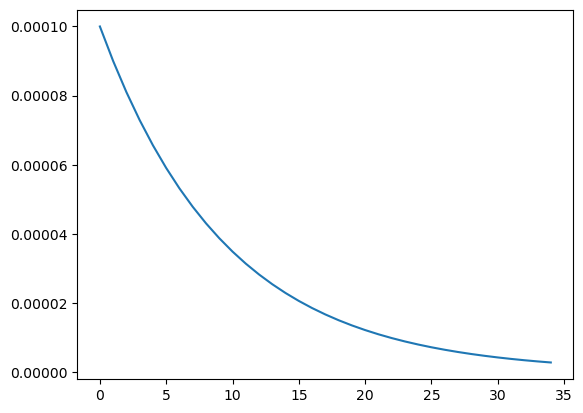

In [13]:
EPOCHS = 35
# Define learning rate scheduler
def lr_scheduler(EPOCHS):
    lr = 1e-4 * (0.9 ** EPOCHS)  # Starting from 1e-4, decrease by 10% every epoch
    return lr

rang = np.arange(EPOCHS)
y = [lr_scheduler(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [14]:
# Callbacks for model training
lr_decay = LearningRateScheduler(lambda epoch: lr_scheduler(epoch), verbose=True)

# Training Data Preparation

Before training our diabetic retinopathy detection model, it's essential to understand the amount of training data available and the number of steps per epoch. These details are crucial for configuring the training process effectively.

- **Number of Training Images:** The variable `num_training_images` represents the total number of training images available. We calculate this by iterating through the TFRecord files containing the training data. For each file (`f`) in `train_filenames`, we count the number of records in that file. This provides an accurate count of the total training images, considering the entire dataset.

- **Steps per Epoch:** `steps_per_epoch` is a critical parameter for training neural networks using mini-batch stochastic gradient descent (SGD). It determines how many batches of data are processed in each training epoch. We calculate `steps_per_epoch` by dividing the `num_training_images` by the batch size. This calculation ensures that the model trains on the entire dataset in a controlled and efficient manner, as it iterates through smaller batches of data in each epoch.

These calculations help us configure our training process to make the most efficient use of the available training data and compute resources. Understanding the number of training images and steps per epoch is vital for setting the appropriate training hyperparameters and ensuring the model's convergence.


In [15]:
# Calculate the number of training images
num_training_images = sum([sum(1 for _ in tf.data.TFRecordDataset(f, num_parallel_reads=AUTO)) for f in train_filenames])
print(num_training_images)
# Calculate steps_per_epoch
steps_per_epoch = num_training_images // batch_size
print(steps_per_epoch)

3045
190


# Training the Diabetic Retinopathy Detection Model

We've configured and prepared our model and data for training. Now, let's dive into the actual training process and how we evaluate the model's performance.

- **Training Process:** The `model.fit` method is used to train our diabetic retinopathy detection model. Here's a breakdown of its key parameters:

    - `training_dataset`: This is our training data, prepared as a TensorFlow dataset. It contains images and their corresponding labels.

    - `steps_per_epoch`: This parameter determines how many batches of data are processed in each training epoch. It's set to ensure that the entire training dataset is processed over multiple epochs.

    - `epochs`: We specify the number of training epochs, which represents how many times the model will iterate through the entire training dataset. In this case, we're training for 50 epochs.

    - `validation_data`: We also provide a validation dataset (`validation_dataset`) to assess the model's performance on data it hasn't seen during training. This helps us monitor for overfitting and generalization.

    - `callbacks`: A list of callbacks to be applied during training. In this case, we're using a callback called `lr_decay` for learning rate scheduling.

    - `class_weight`: We pass the class weights as `class_weight_dict` to account for class imbalance in our dataset. This helps the model give more importance to underrepresented classes during training.

- **Final Accuracy Mean-5:** After training for 50 epochs, we calculate the model's final accuracy. To reduce the impact of any outliers, we compute the mean accuracy of the last five validation epochs. This provides a more stable measure of the model's performance.

    - `history.history["val_accuracy"][-5:]` extracts the validation accuracy of the last five epochs.

    - `np.mean(final_accuracy)` calculates the mean accuracy from these five values.

Monitoring the final accuracy is crucial, as it indicates how well the model has learned to classify diabetic retinopathy from retinal images. A higher accuracy generally implies better performance, but it should be considered along with other evaluation metrics for a comprehensive assessment of the model's quality.


In [16]:
history = model.fit(
    training_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=[lr_decay],
    class_weight=class_weight_dict  # Pass the class weights here
)

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/35
190/190 [==============================] - 78s 229ms/step - loss: 4.1604 - accuracy: 0.5086 - val_loss: 2.3075 - val_accuracy: 0.2151 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9e-05.
Epoch 2/35
190/190 [==============================] - 44s 232ms/step - loss: 1.6821 - accuracy: 0.5589 - val_loss: 1.4563 - val_accuracy: 0.3924 - lr: 9.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 8.1e-05.
Epoch 3/35
190/190 [==============================] - 43s 226ms/step - loss: 1.4251 - accuracy: 0.5622 - val_loss: 1.0450 - val_accuracy: 0.5534 - lr: 8.1000e-05

Epoch 4: LearningRateScheduler setting learning rate to 7.290000000000001e-05.
Epoch 4/35
190/190 [==============================] - 42s 222ms/step - loss: 1.3428 - accuracy: 0.6076 - val_loss: 1.2389 - val_accuracy: 0.6141 - lr: 7.2900e-05

Epoch 5: LearningRateScheduler setting learning rate to 6.561e-05.
Epoch 5/3

# Training Curve Visualization

Visualizing training curves is essential for understanding how our diabetic retinopathy detection model is learning during training. We track two key metrics: accuracy and loss, over multiple epochs. Let's break down the provided code:

- **Accuracy Curve:** The top subplot displays the accuracy curve. It shows how the accuracy of our model changes with each training epoch. The x-axis represents the number of epochs, while the y-axis represents accuracy. The blue line represents training accuracy, and the orange line represents validation accuracy.

- **Loss Curve:** The bottom subplot displays the loss curve. Similar to the accuracy curve, it shows how the loss (error) of our model changes during training. Lower values indicate better performance. The blue line represents training loss, and the orange line represents validation loss.

By visualizing these curves, we can observe important trends:

- **Training Accuracy:** The blue line indicates how well the model is fitting the training data. We want to see it steadily increase, indicating that the model is learning.

- **Validation Accuracy:** The orange line shows how well the model generalizes to unseen data (validation set). Ideally, it should also increase or remain stable. If it significantly diverges from the training accuracy, it could indicate overfitting (fitting the training data too closely).

- **Training Loss:** The blue line represents the training loss, which should steadily decrease as the model learns. Increasing loss would suggest the model is struggling to fit the training data.

- **Validation Loss:** The orange line represents the validation loss. Similar to accuracy, we want it to decrease or remain stable. A significant increase in validation loss relative to training loss can be a sign of overfitting.

This visualization helps us make informed decisions during model training and fine-tuning. If the validation accuracy plateaus or decreases while training accuracy continues to increase, it may be necessary to adjust model complexity, regularization, or other hyperparameters to improve generalization.


/tmp/ipykernel_28/685894748.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


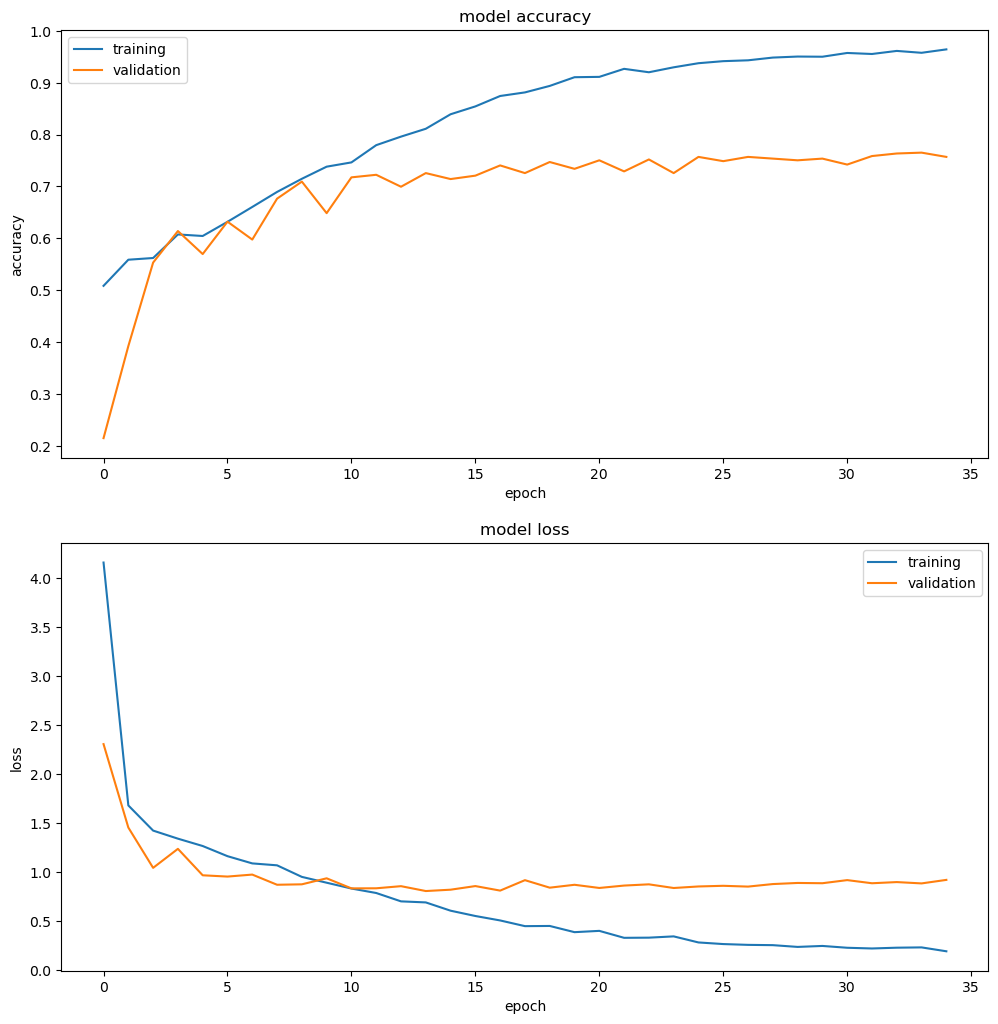

In [17]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

# Image Visualization with Titles

In this visualization, we display a batch of images along with their titles. Each image is accompanied by a title that provides information about the model's prediction for the disease's class.

- **Image Grid:** The grid displays multiple images.

- **Image Titles:** The titles above each image describe the classification result. There are two types of titles:
    - **Correct Predictions (Black):** If the model's prediction matches the actual class label, the title appears in black. It indicates that the model correctly identified the disease's class.
    - **Incorrect Predictions (Red):** If the model's prediction differs from the actual class label, the title appears in red. It also mentions what the correct class should have been.

This visualization allows us to assess how well the model is performing on the validation dataset. Correct predictions are an indicator of the model's accuracy, while incorrect predictions highlight areas where the model may need improvement.

By examining the images and titles, we can gain insights into the model's strengths and weaknesses. It's particularly helpful for identifying cases where the model is struggling to classify certain disease types.

Feel free to re-run this cell to view different batches of images and their corresponding titles, allowing you to assess the model's performance visually.


In [18]:
def disease_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
  class_idx = np.argmax(label, axis=-1)
  prediction_idx = np.argmax(prediction, axis=-1)
  if class_idx == prediction_idx:
    return f'{label_names[prediction_idx]} [correct]', 'black'
  else:
    return f'{label_names[prediction_idx]} [incorrect, should be {label_names[class_idx]}]', 'red'

def get_titles(images, labels, model):
  predictions = model.predict(images)
  titles, colors = [], []
  for label, prediction in zip(labels, predictions):
    title, color = disease_title(label, prediction)
    titles.append(title)
    colors.append(color)
  return titles, colors

validation_viz_iterator = get_dataset_iterator(validation_dataset, 9)

In [19]:
# Re-run this cell to show a new batch of images
images, classes = next(validation_viz_iterator)
titles, colors = get_titles(images, classes, model)


1/1 [==============================] - 2s 2s/step


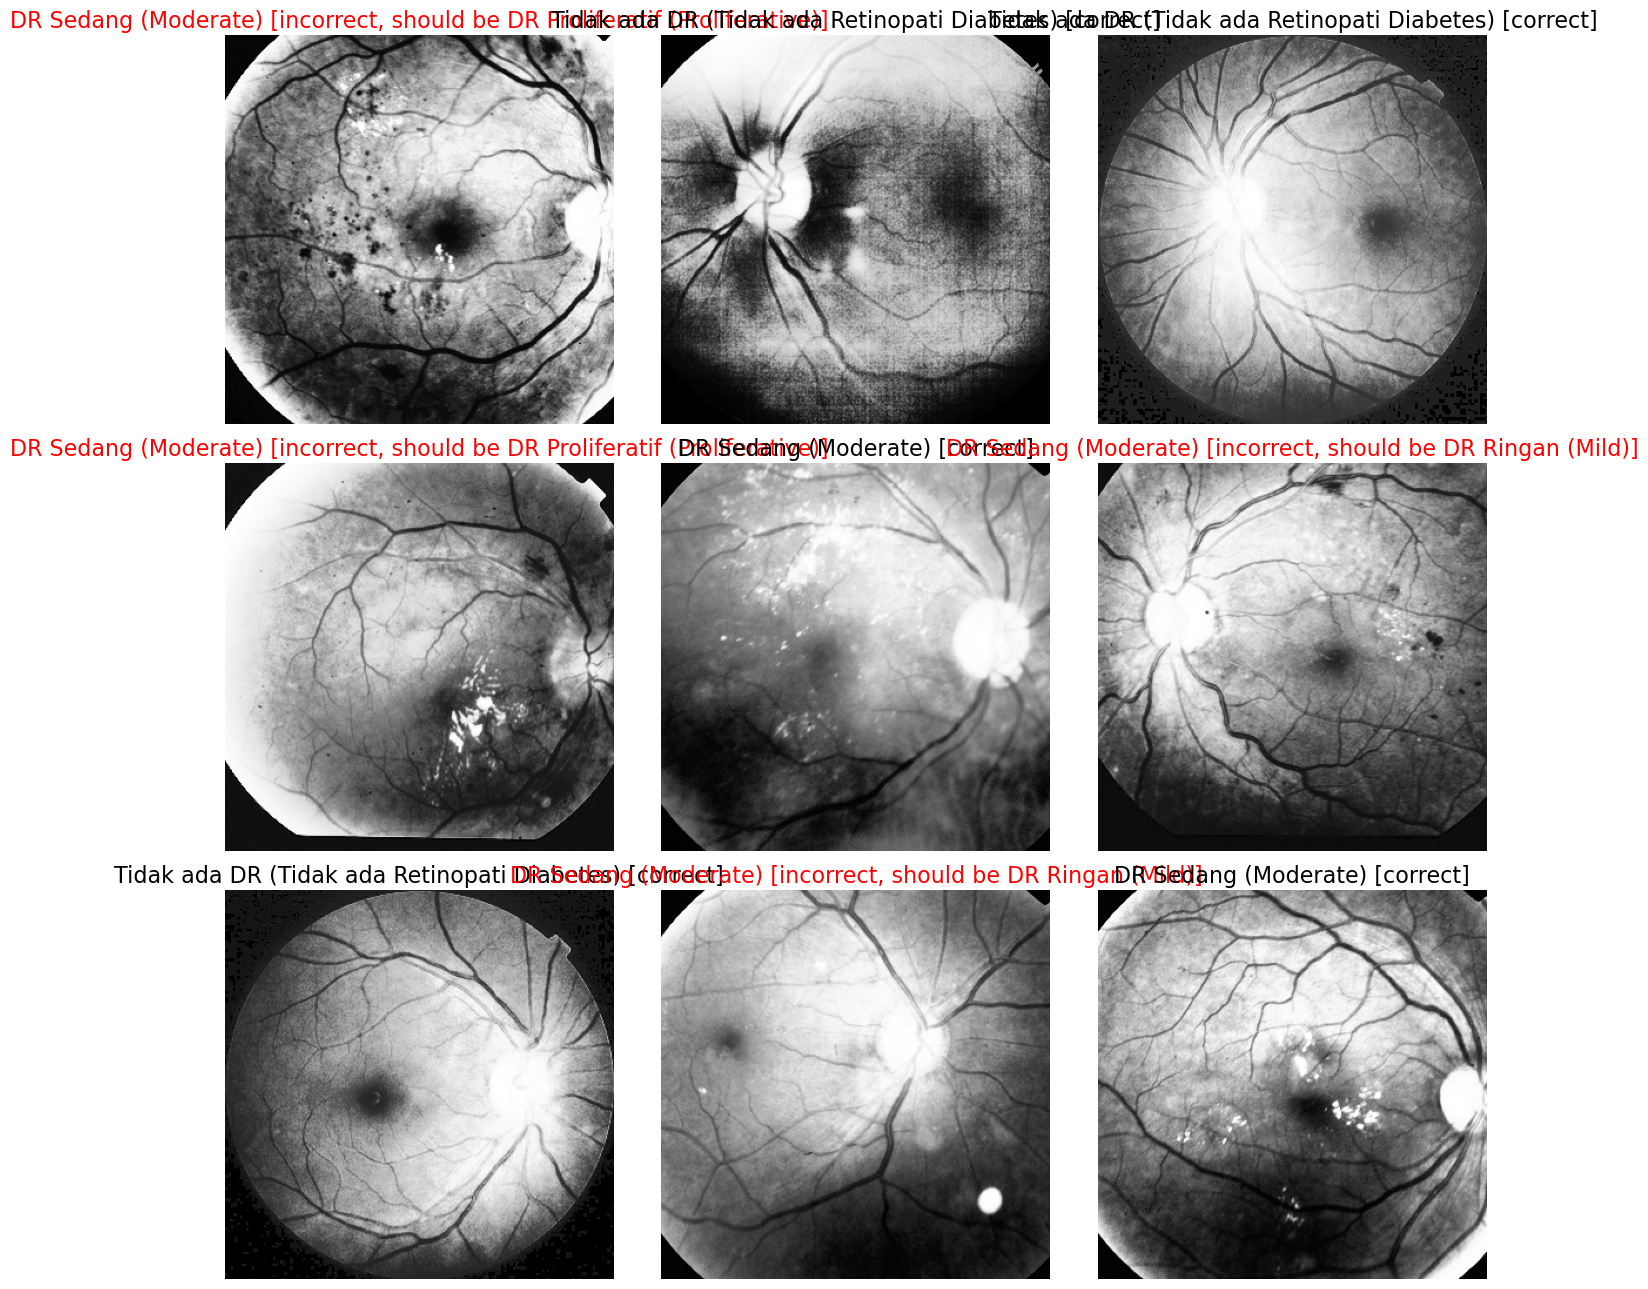

In [20]:
display_nine_images(images, titles, colors)

# Save Trained Model

The trained model has been saved as 'best_model2.h5'. This saved model file contains the learned weights, architecture, and configuration of the model. Saving the model allows us to reuse it for various purposes, such as making predictions on new data or fine-tuning it for further training.

To load this saved model in the future, you can use the following code:

```python
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('best_model2.h5')


In [21]:
model.save('best_model.h5')

In [22]:
import tensorflowjs as tfjs

In [25]:
# Memuat model dari file 'best_model.h5'
test = tf.keras.models.load_model('best_model.h5')

# Menampilkan ringkasan model
test.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 329, 329, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 164, 164, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 164, 164, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 162, 162, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 81, 81, 128)      0         
 2D)                                                             
                                                        

# Purpose of Creating a ZIP File

We are creating a ZIP file to simplify the process of downloading the trained model. This compressed archive, named 'out1.zip', contains the model file ('best_model2.h5').

By using a ZIP file, you can easily download the model to your local machine. Once downloaded, you can unzip the file to access the saved model. This streamlined approach ensures a convenient and efficient way to obtain and work with the trained model.


In [ ]:
import zipfile

with zipfile.ZipFile('out1.zip', 'w') as zipf:
    zipf.write('/kaggle/working/best_model2.h5', 'best_model.h5')

# Conclusion

In this project, we've developed a deep learning model to detect and classify diabetic retinopathy (DR) into five severity categories, ranging from 'No DR' to 'Proliferative DR.' Leveraging a Kaggle dataset and the power of a TPU VM (v3.8), we've undertaken various steps:

- Preprocessed and resized retinal images.
- Created TFRecord files for efficient data input.
- Designed a convolutional neural network (CNN) model.
- Implemented learning rate scheduling for training optimization.
- Managed class imbalances with class weights.
- Trained and evaluated the model with TensorFlow and Keras.

The resulting model can assist in the early detection and severity classification of diabetic retinopathy, potentially aiding in preventing vision loss for diabetic individuals.

Thank you for joining this journey towards leveraging AI for healthcare. Feel free to download the model and explore its applications further.
